In [1]:
%load_ext autoreload
%autoreload 2
%aimport anndata
%aimport os
%aimport torch
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from typing import Dict, Union, List, Tuple
from torch.utils.data import Dataset
# Control UMAP numba warnings
import warnings; warnings.simplefilter('ignore')
import copy
import scvi
from scvi.dataset import CortexDataset, RetinaDataset, CsvDataset
from scvi.models import VAE
from scvi.inference import UnsupervisedTrainer, load_posterior
from scvi import set_seed
from scvi.dataset.utils import setup_anndata

#STUFF THAT I MESSED AROUND WITH
# from BioDataset import BioDataset
# from constants import X_KEY, BATCH_KEY, LOCAL_L_MEAN_KEY, LOCAL_L_VAR_KEY, LABELS_KEY

# Sets torch and numpy random seeds, run after all scvi imports
set_seed(0)


In [2]:
save_path = "data/"
gene_dataset = CortexDataset(save_path=save_path, total_genes=None)
gene_dataset.subsample_genes(1000, mode="variance")
gene_dataset.make_gene_names_lower()

adata = gene_dataset.to_anndata()
setup_anndata(adata,batch_key='batch_indices', labels_key = 'precise_labels' )

[2020-06-17 00:39:56,431] INFO - scvi.dataset.dataset | File /Users/galen/scVI/galen/data/expression.bin already downloaded
[2020-06-17 00:39:56,433] INFO - scvi.dataset.cortex | Loading Cortex data
[2020-06-17 00:40:05,005] INFO - scvi.dataset.cortex | Finished preprocessing Cortex data
[2020-06-17 00:40:06,173] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-06-17 00:40:06,174] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-06-17 00:40:08,003] INFO - scvi.dataset.dataset | Downsampling from 19972 to 1000 genes
[2020-06-17 00:40:08,124] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-06-17 00:40:08,136] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-06-17 00:40:08,204] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-06-17 00:40:08,209] INFO - scvi.dataset.dataset | Downsampled from 3005 to 3005 cells
[2020-06-17 00:40:08,219] INFO - scvi.dataset.dataset | Making gen

In [4]:
adata = gene_dataset.to_anndata()
setup_anndata(adata,batch_key='batch_indices', labels_key = 'precise_labels' )


[2020-06-17 00:40:22,988] INFO - scvi.dataset.utils | Using data from adata.X
[2020-06-17 00:40:22,989] INFO - scvi.dataset.utils | Using batches from adata.obs["batch_indices"]
[2020-06-17 00:40:22,990] INFO - scvi.dataset.utils | Using labels from adata.obs["precise_labels"]
[2020-06-17 00:40:23,005] INFO - scvi.dataset.utils | Calculating log mean and log variance per batch
[2020-06-17 00:40:23,021] INFO - scvi.dataset.utils | Successfully registered anndata object containing 3005 cells, 1000 genes, and 1 batches 
Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']


In [5]:
adata.uns['scvi_data_registry']

{'X': (None, 'X'),
 'batch_indices': ('obs', 'batch_indices'),
 'local_l_mean': ('obs', '_scvi_local_l_mean'),
 'local_l_var': ('obs', '_scvi_local_l_var'),
 'labels': ('obs', '_scvi_labels')}

In [6]:
n_epochs = 10
lr = 1e-3
use_cuda = True

#nbatch, ngenes, nproteins
vae = VAE(adata.shape[1], n_batch = adata.uns['scvi_summary_stats']['n_batch'])
trainer = UnsupervisedTrainer(
    vae,
    adata,
    train_size=0.90,
    n_epochs_kl_warmup = 2,
    use_cuda=use_cuda,
    frequency=5,
)
trainer.train(n_epochs = n_epochs)

[2020-06-17 00:40:37,784] INFO - scvi.inference.inference | KL warmup for 2 epochs


In [7]:
full = trainer.create_posterior(trainer.model, adata, indices=np.arange(len(gene_dataset)))
full = full.update({"batch_size":32})

In [10]:
latent, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()

In [11]:
imputed_values = full.sequential().imputation()
normalized_values = full.sequential().get_sample_scale()

In [8]:
cell_types = gene_dataset.cell_types
print(gene_dataset.cell_types)
# oligodendrocytes (#4) VS pyramidal CA1 (#5)
couple_celltypes = (4, 5)  # the couple types on which to study DE

print("\nDifferential Expression A/B for cell types\nA: %s\nB: %s\n" %
      tuple((cell_types[couple_celltypes[i]] for i in [0, 1])))

cell_idx1 = gene_dataset.labels.ravel() == couple_celltypes[0]
cell_idx2 = gene_dataset.labels.ravel() == couple_celltypes[1]

['astrocytes_ependymal' 'endothelial-mural' 'interneurons' 'microglia'
 'oligodendrocytes' 'pyramidal CA1' 'pyramidal SS']

Differential Expression A/B for cell types
A: oligodendrocytes
B: pyramidal CA1



In [9]:
n_samples = 100
M_permutation = 100000

In [10]:
de_res = full.differential_expression_score(
    cell_idx1,
    cell_idx2,
    n_samples=n_samples,
    M_permutation=M_permutation,
)


In [11]:
de_res

,proba_m1,proba_m2,bayes_factor,scale1,scale2,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2
fabp5,1.0,0.0,18.420681,0.003008,0.000499,13.097561,3.468584,0.963415,0.802982,2.332166,0.348048
mobp,1.0,0.0,18.420681,0.004691,0.000218,30.704878,1.108626,0.993902,0.104366,4.990324,0.112512
gatm,1.0,0.0,18.420681,0.002664,0.000118,12.093903,0.500533,0.976829,0.177849,2.062968,0.056258
slc38a2,1.0,0.0,18.420681,0.002861,0.000362,12.426829,1.995740,0.937805,0.697551,2.064762,0.219480
cd9,1.0,0.0,18.420681,0.003271,0.000219,17.135366,0.855165,0.973171,0.167199,2.610595,0.100151
...,...,...,...,...,...,...,...,...,...,...,...
3110035e14rik,0.0,1.0,-18.420681,0.000281,0.002257,1.092683,17.684771,0.219512,0.991480,0.163012,1.890319
tspan13,0.0,1.0,-18.420681,0.000183,0.002378,0.531707,22.612354,0.193902,0.996805,0.081057,2.406704
slc8a1,0.0,1.0,-18.420681,0.000326,0.001883,1.060976,20.086262,0.352439,0.991480,0.174123,2.100040
pja2,0.0,1.0,-18.420681,0.000600,0.001854,2.174390,22.217253,0.669512,1.000000,0.340402,2.388140


In [12]:
genes_of_interest = ["thy1", "mbp"]
de_res.filter(items=genes_of_interest, axis=0)

,proba_m1,proba_m2,bayes_factor,scale1,scale2,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2
thy1,0.0,1.0,-18.420681,0.000193,0.001996,0.589024,13.569755,0.219512,0.996805,0.089729,1.444312
mbp,1.0,0.0,18.420681,0.012464,0.000534,55.318295,2.787008,0.998780,0.452609,8.840034,0.298456


In [13]:
per_cluster_de, cluster_id = full.one_vs_all_degenes(cell_labels=gene_dataset.labels.ravel(), min_cells=1)

markers = []
for x in per_cluster_de:
    markers.append(x[:10])
markers = pd.concat(markers)

genes = np.asarray(markers.index)
expression = [x.filter(items=genes, axis=0)['raw_normalized_mean1'] for x in per_cluster_de]
expression = pd.concat(expression, axis=1)
expression = np.log10(1 + expression)
expression.columns = gene_dataset.cell_types

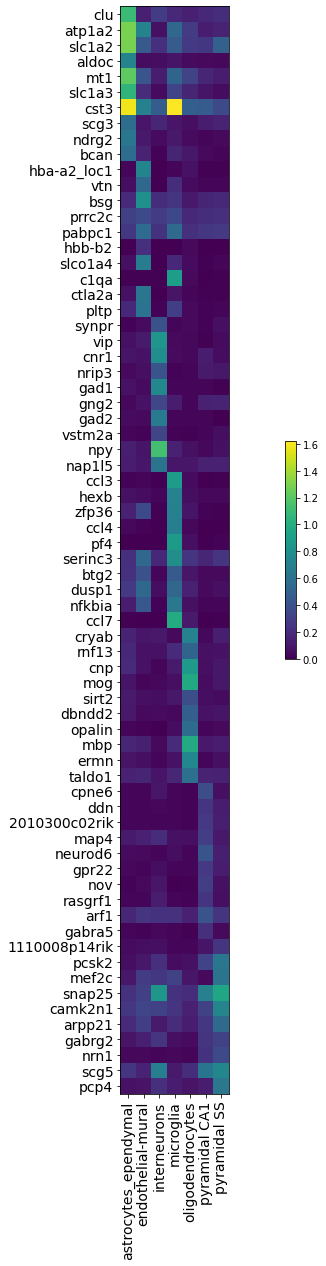

In [14]:
%matplotlib inline
plt.figure(figsize=(20, 20))
im = plt.imshow(expression, cmap='viridis', interpolation='none', aspect='equal')
ax = plt.gca()
ax.set_xticks(np.arange(0, 7, 1))
ax.set_xticklabels(gene_dataset.cell_types, rotation='vertical')
ax.set_yticklabels(genes)
ax.set_yticks(np.arange(0, 70, 1))
ax.tick_params(labelsize=14)
plt.colorbar(shrink=0.2)
